In [2]:
%matplotlib inline
#%matplotlib ipympl
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)


In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create a session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

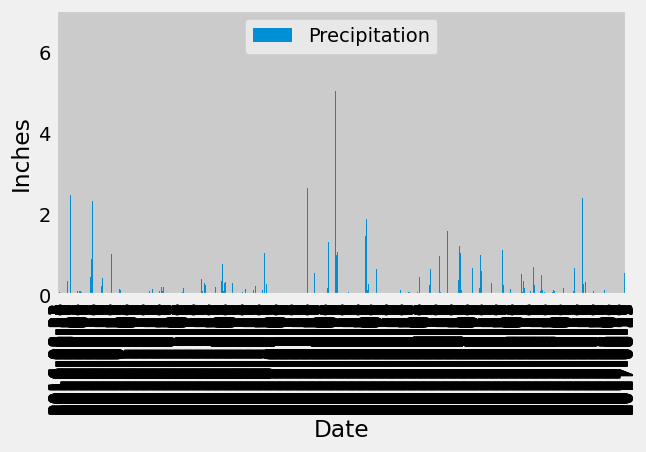

In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
past_year_date = dt.date(2017,8,23)-dt.timedelta(days = 365 )

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= past_year_date)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_df = pd.DataFrame(data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
sorted_data_df = data_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
sorted_data_df.set_index('Date', inplace=True)
sorted_data_df.plot.bar()
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel('Inches')
plt.grid(True)
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
agg_stat_summary = sorted_data_df["Precipitation"].agg(
    count='count', 
    mean='mean', 
    std='std', 
    min='min', 
    q25=lambda x: x.quantile(0.25),
    q50=lambda x: x.quantile(0.50),
    q75=lambda x: x.quantile(0.75),
    max = 'max'
)
pd.DataFrame(agg_stat_summary)


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
q25,0.000000
q50,0.020000
q75,0.130000
max,6.700000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station).distinct().count()

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Station.station,
       func.count(Measurement.station)]
session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Station.station == Measurement.station).filter(Station.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

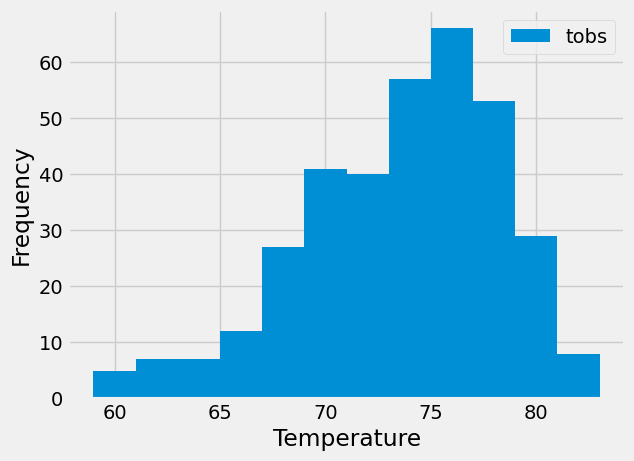

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data_temp = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
temperature = [temp[0] for temp in data_temp]
temperature
plt.hist(temperature,bins=12,label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [57]:
# Close Session
session.close()
